I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track of their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insights on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install praw duckdb jupysql bertopic groq pyabsa tqdm --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import os
from pprint import pprint
from tqdm import trange, tqdm, tqdm_notebook # progress bar for run time >30 min

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 
from math import pi
import plotly.express as px

# Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

# Named Entity Recognition
import spacy 
import requests 
from bs4 import BeautifulSoup
nlp = spacy.load("en_core_web_sm")
pd.set_option("display.max_rows", 200)

from spacy import displacy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-07-13 23:23:31.254944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 23:23:31.255177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 23:23:31.436731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-13 23:24:13] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# YouTube and Reddit Data

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [4]:
user_secrets = UserSecretsClient()

In [5]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [6]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [7]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

author          published_at  like_count  \
1690        @Darr1071  2024-06-12T06:58:57Z           0   
5541  @EpicLootBox786  2024-06-11T13:08:34Z           0   
7760    @larryace4683  2024-06-11T09:13:48Z           0   
5275  @samhickman3813  2024-06-11T13:39:44Z           0   
4478   @rainshadows17  2024-06-11T15:22:58Z           0   

                                                                                                                                                                                                                                                                                                                                                                     text  \
1690                                                                                                                                                                                                                                                                                                              iOS 18 and Apple Intelligence are going to bury Android   
5541                                                                                                                                                                                                                                      Soo all of this was already on Android, now it's on Apple. This show's how many stupid people live in the world that use apple.   
7760                                                                                                                                                                                                                                                                                                                                                  I was expecting iAI   
5275  Genmoji is the feature I am most excited for.  The Unicode Consortium has been actively suppressing the movement for a raisin emoji.  Until now we have had to use a sunshine and a grape emoji to denote raisins, so the first thing I will be doing with my new device is making a raisin emoji. \n\nThe rest is more the usual shuffling deck chairs iOS update.   
4478                                                                                                                                                                                                                                                                                                  Yhe only thing im kinda intrigued by is the EMOJI customisation lol   

         video_id  
1690  qkYoBNdcXBU  
5541  qkYoBNdcXBU  
7760  qkYoBNdcXBU  
5275  qkYoBNdcXBU  
4478  qkYoBNdcXBU

In [8]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [9]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

author        published_at  like_count  \
6698  @Random.ChanneI 2024-06-11 11:02:29           0   
651          @eudofia 2024-06-13 22:47:30           0   
3307     @_TheFlash12 2024-06-11 18:37:23           0   
3921   @kingkaran4459 2024-06-11 16:43:30           0   
2889   @iT3chWithNate 2024-06-11 20:18:23           1   

                                                                                                                                                                     text  \
6698                    I want to be able to remove that app names. The icons are just enough for me. Imagine how clean it would look without all the tex under each app.   
651   12:38. The writing tool is basically a copy of Grammerly, which has existed for more than 10 years now. Now all IOS users will think Apple just invented the wheel.   
3307                                                                                                                                             I have mine on dark mode   
3921                                                                               I felt very happy until I realised that AI features are available for Pro models only.   
2889                                                                                                       Math notes would have saved me so much in school. I’m jealous.   

     youtube_channel published_at_date  published_at_month  
6698           MKBHD        2024-06-11                   6  
651            MKBHD        2024-06-13                   6  
3307           MKBHD        2024-06-11                   6  
3921           MKBHD        2024-06-11                   6  
2889           MKBHD        2024-06-11                   6

In [10]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9833
The Verge     483
Name: count, dtype: int64

In [11]:
df0['app'] = 'YouTube'

In [12]:
len(df0)

10316

In [13]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [14]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [15]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [16]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [17]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         810   
1                   6         527   
2                   6         875   
3                   6         136   
4                   6          93   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [18]:
len(reddit_df)

1343

In [19]:
reddit_df['app'] = 'Reddit'

In [20]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [21]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [22]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [23]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11659

In [24]:
df.head()

author        published_at  like_count  \
0          @Gaud-fk3nv 2024-07-13 21:39:50           0   
1     @user-wq2re1rd6o 2024-07-13 21:39:47           0   
2         @HYDGAMER786 2024-07-13 21:39:45           0   
3  @NamitaMondal-zw5yh 2024-07-13 21:39:38           0   
4    @GuduPujari-iu7vp 2024-07-13 21:39:36           0   

                                                                                                  text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date  published_at_month      app  
0        2024-07-13                   7  YouTube  
1        2024-07-13                   7  YouTube  
2        2024-07-13                   7  YouTube  
3        2024-07-13                   7  YouTube  
4        2024-07-13                   7  YouTube

____
# Data Augmentation with Synonyms 
Future use. It was not used here given Groq's limitations and sufficient conclusions given volume of data retrieved.

In [25]:
# If there is not enough data, augment data with synonyms. 
# (This was explored since Groq API had issues with >100 predictons at one time.) 
# However, the code is below just in case it is needed in the future for better model training and therefore prediction. 
# At the same time, picking a model that understands variance in data is another approach at high inference accuracy.

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def replace_with_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            new_text.append(synonyms[0])  # Replace with the first synonym
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Load a pre-trained model for masked language modeling
unmasker = pipeline('fill-mask', model='bert-base-uncased')

def replace_with_contextual_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        if wordnet.synsets(word):  # Check if word has synonyms
            masked_text = text.replace(word, '[MASK]', 1)
            suggestions = unmasker(masked_text)
            best_synonym = suggestions[0]['token_str']  # Get the best synonym
            new_text.append(best_synonym)
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Test the functions
sample_text = "The quick brown fox jumps over the lazy dog."

# Basic synonym replacement
augmented_text = replace_with_synonyms(sample_text)
print("Basic Synonym Replacement:", augmented_text)

# Contextual synonym replacement
contextual_augmented_text = replace_with_contextual_synonyms(sample_text)
print("Contextual Synonym Replacement:", contextual_augmented_text)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1107: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/lexnames'>
  for i, line in enumerate(self.open('lexnames')):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adj'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adv'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.noun'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/n

Basic Synonym Replacement: The promptly brownish discombobulate bound concluded the work-shy dog.
Contextual Synonym Replacement: The little thinking cat watched at the little dog.


Both are not that great because these sentences would not be used in real life. I would use Groq again in order to have better quality synonyms. 

In [26]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            I am trying to test out some data augmentation methods using word replacement with synonyms. 
            Given this sentence, please create an alternative or alternatives, but similar sentence using synonyms:
            The quick brown fox jumps over the lazy dog.
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

'What a classic sentence!\n\nHere are some alternative sentences using synonyms:\n\n1. **The swift rust-colored fox leaps over the sluggish hound.**\n\t* Quick -> Swift\n\t* Brown -> Rust-colored\n\t* Jumps -> Leaps\n\t* Lazy -> Sluggish\n\t* Dog -> Hound\n2. **The rapid tawny fox bounds over the indolent canine.**\n\t* Quick -> Rapid\n\t* Brown -> Tawny\n\t* Jumps -> Bounds\n\t* Lazy -> Indolent\n\t* Dog -> Canine\n3. **The fleet sandy fox springs over the idle pup.**\n\t* Quick -> Fleet\n\t* Brown -> Sandy\n\t* Jumps -> Springs\n\t* Lazy -> Idle\n\t* Dog -> Pup\n\nI hope these alternatives help you test your data augmentation methods!'

Awesome, just as I predicted, LLM is much better than NLTK algorithms. :)
____

# BERTopic Modeling

In [27]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-13 23:25:33,104 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-07-13 23:27:10,760 - BERTopic - Embedding - Completed ✓
2024-07-13 23:27:10,762 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-13 23:27:47,427 - BERTopic - Dimensionality - Completed ✓
2024-07-13 23:27:47,429 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-13 23:27:56,947 - BERTopic - Cluster - Completed ✓
2024-07-13 23:27:56,959 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-13 23:28:16,175 - BERTopic - Representation - Completed ✓


Topic  Count                                                 Name  \
0       -1   2565                            -1_like_ai_features_video   
1        0   1001              0_calculator_ipad_handwriting_equations   
2        1    528                    1_siri_typing_accessibility_voice   
3        2    376                             2_notes_mkbhd_read_event   
4        3    315                            3_ai_apple_marketing_term   
5        4    264                       4_apple_late_products_innovate   
6        5    254                         5_icons_change_colors_screen   
7        6    248                                 6_15_pro_ai_features   
8        7    214                             7_s24_ultra_galaxy_notes   
9        8    204                                   8_ai_tech_times_ml   
10       9    202                         9_apple_cringe_genius_insult   
11      10    195                              10_ios18_beta_update_17   
12      11    179                        11_tinder_grindr_wives_folder   
13      12    170                                       12_30_11_38_07   
14      13    164                                13_thanks_yo_lol_epic   
15      14    163                        14_privacy_data_cloud_compute   
16      15    158                     15_apple_users_hardware_features   
17      16    151                                16_ipados_file_pro_m4   
18      17    148                     17_iphone_features_finally_users   
19      18    120                     18_emojis_custom_robber_genmojis   
20      19    115                    19_mirroring_remote_huawei_screen   
21      20    115                           20_pro_14_outdated_battery   
22      21    109                        21_homescreen_ugly_users_make   
23      22    104                         22_pro_15_intelligence_cloud   
24      23     83                23_keynote_podcast_platforms_waveform   
25      24     83                   24_lighting_grading_sunset_setting   
26      25     83                          25_vr_announced_visionos_4k   
27      26     77              26_subscribers_youtube_presentations_1m   
28      27     77                        27_chatgpt_integration_4o_api   
29      28     77                       28_marques_samsung_notes_funny   
30      29     74                           29_openai_elon_trust_train   
31      30     70               30_images_artists_generative_copyright   
32      31     68                         31_mkb_hey_studio_thumbnails   
33      32     66  32_messages_scheduling_jerryrigeverything_shortcuts   
34      33     65                        33_song_intros_houdini_logics   
35      34     61                34_chatgpt_gpt_integration_confirming   
36      35     60                   35_updates_zombie_dokkan_equalizer   
37      36     59                                  36_db_bvg_bahn_apps   
38      37     56                        37_marques_pedro_batman_proud   
39      38     55                  38_chapters_계선기_backgraund_apostasy   
40      39     54          39_keyboard_unplug_autocorrect_accidentally   
41      40     54                    40_satellite_sms_skynet_emergency   
42      41     53               41_upgrade_supported_generations_14pro   
43      42     52                  42_features_hardware_software_apple   
44      43     51                   43_vid_brighter_thanks_informative   
45      44     51                   44_organize_filter_recents_gallery   
46      45     49                 45_genmojis_excited_uncanny_stickers   
47      46     49                     46_options_android_users_smaller   
48      47     48                          47_homepods_siri_pods_dates   
49      48     48                48_passwords_icloud_keychain_nordpass   
50      49     47                         49_hotel_lighting_studio_set   
51      50     47                     50_window_snapping_mac_rectangle   
52      51     46                          51_minutes_gang_lesgo_coool   
53      5

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [28]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
# df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-13 23:28:57,438 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-13 23:29:07,828 - BERTopic - Dimensionality - Completed ✓
2024-07-13 23:29:07,829 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-13 23:29:14,932 - BERTopic - Cluster - Completed ✓
2024-07-13 23:29:14,945 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-13 23:29:31,676 - BERTopic - Representation - Completed ✓


CPU times: user 1min 39s, sys: 22.5 s, total: 2min 1s
Wall time: 1min 14s


Topic  Count                                                Name  \
0       -1   4310                         -1_android_features_like_ai   
1        0    640                         0_samsung_reading_s24_notes   
2        1    570                     1_siri_type_accessibility_voice   
3        2    486                                  2_15_pro_iphone_ai   
4        3    397                     3_apple_intelligent_sounds_term   
5        4    365                        4_icons_apps_homescreen_ugly   
6        5    354                 5_apple_innovation_shill_propaganda   
7        6    253                              6_ai_tech_marketing_ml   
8        7    250                       7_calculator_app_notes_pencil   
9        8    187                        8_android_apple_copying_fans   
10       9    172                    9_notes_equations_calculus_maths   
11      10    167                        10_data_privacy_openai_cloud   
12      11    160                             11_ipad_m4_need_macbook   
13      12    126                  12_emojis_custom_stickers_genmojis   
14      13    107                   13_calculator_app_mathcad_college   
15      14    103                   14_mirroring_remote_vision_huawei   
16      15     94               15_calculator_thing_photomath_fucking   
17      16     86                        16_tinder_grindr_wives_hides   
18      17     81                          17_intros_eminem_logics_85   
19      18     80  18_1179_markass_fantasic_这就是中国全部手机公司市值的科技公司所做出来的创新   
20      19     72                    19_ios_xiaomi_18mins_bootloaders   
21      20     68                  20_math_calculator_equations_notes   
22      21     68                    21_window_snapping_mac_rectangle   
23      22     62                           22_ios_closer_turning_soo   
24      23     61                      23_jailbreak_cydia_ipod_tweaks   
25      24     59                     24_underwhelming_12_lame_ipados   
26      25     58                         25_ai_trademark_apple_train   
27      26     57                               26_beta_dev_pjpg_webp   
28      27     56                   27_lighting_grading_hotel_amazing   
29      28     54                    28_pause_calls_forgot_recordings   
30      29     49                               29_berlin_db_bvg_bahn   
31      30     48                30_subscribers_19m_congrats_youtuber   
32      31     47                        31_lighting_studio_set_rooms   
33      32     46                             32_ram_models_a16_older   
34      33     43                             33_dope_oof_legend_luck   
35      34     42            34_vision_announced_sprinter_paperweight   
36      35     42                35_handwriting_note_freeform_onenote   
37      36     41              36_passwords_app_icloud_authentication   
38      37     40                          37_wwdc_keynote_miss_event   
39      38     40                    38_garmin_fitness_rings_tracking   
40      39     40                          39_elon_musk_wahhh_tweeted   
41      40     39               40_images_artists_generate_generative   
42      41     39             41_scheduled_imessage_shortcuts_message   
43      42     39                       42_rcs_mentioned_adds_support   
44      43     38          43_updates_underwhelming_bulgarians_lamest   
45      44     38                   44_keyboard_jokes_unplugged_users   
46      45     37                       45_satellite_sms_service_node   
47      46     37                      46_android_2010_chromies_noobs   
48      47     37                                       47_deleted___   
49      48     36                              48_rabbit_pin_scam_rip   
50      49     35               49_recap_superlative_reviews_devaluer   
51      50     35                    50_comment_unniyettan_uganda_no1   
52      51     35                        51_lunch_uploading_3am_shift   
53      52     34             52_thanks_vid_informative_encoura

In [29]:
topic_model.get_topic(0) # top topic

[('samsung', 0.10205088339375405),
 ('reading', 0.08246212447081988),
 ('s24', 0.051645830772319094),
 ('notes', 0.037146982292113113),
 ('marques', 0.030986286518239307),
 ('mkbhd', 0.03029989181963548),
 ('updates', 0.020209069673506316),
 ('ios', 0.014249302032336613),
 ('fact', 0.013718137943839855),
 ('recap', 0.01120108000987528)]

These topics seem more interpretable due to better embeddings. (Also, there was an index shift with topic 0 being non-outlier topic, but most popular topic.)

## BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [30]:
topic_model.visualize_topics()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The biggest topic after the outlier topic was topic 0 centered on: samsung, s24, ultra, notes, marques (noise). I used the slider to move across topics. The highlighted bubble helps you see which topic you are examining. This is helpful if you cannot tell which topic you are on based on the slider ticks. When you hover over the bubble, you see the words associated with the topic.

In [31]:
topic_model.visualize_barchart(top_n_topics=8)

We see the top 8 topics and their associated words. The higher the score for a word, the more central it is to the topic. 

In order to get context to explain why these topics are popular, whether or not there is positive/negative sentiment tied to this, had to go to the reference_docs column. This gave me the comments tied to the topics.

Samsung24 Ultra Notes were mentioned only because an Apple presenter was using a competitor to present Apple's latest releases. So many people found this humorous. This would be noise if our goal is to determine what about Apple people liked/disliked.

Huge wins for Apple were announcing their AI integrations, but there was critique/mocking when it came to their Siri, icons and iPad calculator updates. There was bewilderment about whether or not the new features would be available on the base iPhone 15 model or just the Pro and Max versions. Looks like Apple needs to keep working on its brand because it got mixed reviews from its latest updates and future releases.

In [32]:
topic_model.visualize_heatmap()

Cosine Similarity Matrix: This is a table where each cell (i, j) contains the cosine similarity between the embedding of topic i and the embedding of topic j. If the value is close to 1, it means those topics are very similar. If it's close to 0, they are quite different.

Heatmap: This is a graphical representation of the cosine similarity matrix. In a heatmap, colors are used to represent values in the matrix. Typically, darker colors might represent higher similarity (values closer to 1), while lighter colors represent lower similarity (values closer to 0).

___

This Similarity Matrix would be nice if it was broken down into smaller matrices, but the number of possible combinations would be reduced. When hovering over the darkest squares there are some interesting similar topics that are far away in index number, but words within topics were similar. For example, two topics (35 and 66) crossing with similarity score of: 0.748841 have these words in their topics: (35): updates, underwhelming, biggest, ipadOS (66): updates, turning, ios7, wasteland. Similarity is in Apple's updates being disappointing. When looking at the reference doc's for each topic, reference comment for 66 was negative.

* Not sure what the benchmark is for good separation between topics. 
* Topics not along the diagonal are unique topics.
* Most topics are 0.4 or below in similarity score. This means there are nice separate topics discovered under better embeddings and BERTopic model.

# Perform Sentiment and Emotion Classification

In [33]:
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Long comments cause error in model inference because model has cap in total number of tokens as input. To get arround this, will use a tokenizer to determine total tokens per comment. Then will summarize those comments that exceed input max token count. Will use LLM to summarize 
long comments. Finally, before sentiment inference, filter will be used to retain comments that only are below threshold for max token count.

In [34]:
# Need to make comments text as similar as text was for model's training for sentiment inference: remove HTML tags
# Using cased model so case-sentitive text used to train model. So for new data input, no need for lowering text.

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

author        published_at  like_count  \
0          @Gaud-fk3nv 2024-07-13 21:39:50           0   
1     @user-wq2re1rd6o 2024-07-13 21:39:47           0   
2         @HYDGAMER786 2024-07-13 21:39:45           0   
3  @NamitaMondal-zw5yh 2024-07-13 21:39:38           0   
4    @GuduPujari-iu7vp 2024-07-13 21:39:36           0   

                                                                                                  text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date  published_at_month      app  \
0        2024-07-13                   7  YouTube   
1        2024-07-13                   7  YouTube   
2        2024-07-13                   7  YouTube   
3        2024-07-13                   7  YouTube   
4        2024-07-13                   7  YouTube   

                                                                                        processed_text  
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸  
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯  
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮  
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸  
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉

In [35]:
%%time

# 1. Determine total tokens
# 2. Filter out comments that have max: 450 total tokens since tokenizer can add suffixes as a token. So buffering for that.
# 3. Summarize comments using Groq since losing richness of dataset if eliminated comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 2.33 s, sys: 4.62 ms, total: 2.33 s
Wall time: 2.43 s


author        published_at  like_count  \
0          @Gaud-fk3nv 2024-07-13 21:39:50           0   
1     @user-wq2re1rd6o 2024-07-13 21:39:47           0   
2         @HYDGAMER786 2024-07-13 21:39:45           0   
3  @NamitaMondal-zw5yh 2024-07-13 21:39:38           0   
4    @GuduPujari-iu7vp 2024-07-13 21:39:36           0   

                                                                                                  text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date  published_at_month      app  \
0        2024-07-13                   7  YouTube   
1        2024-07-13                   7  YouTube   
2        2024-07-13                   7  YouTube   
3        2024-07-13                   7  YouTube   
4        2024-07-13                   7  YouTube   

                                                                                        processed_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

   num_tokens  
0          27  
1          30  
2          26  
3          26  
4          26

In [36]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [37]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [38]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [39]:
# Testing
 
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here is a condensed version of the comment in 15 sentences or less:\n\nI want to thank you for creating well-thought-out tech videos. I appreciate your expertise and it's helped me learn new things. As a software engineer, I've been writing to Apple for years and believe they've used some of my ideas. I'd like to share them with you. My suggestion is to create a real tech news channel, like a CNN or NBC News, but focused solely on tech. This would be a game-changer and put some tech influencers out of business. I proposed this idea to Apple, but they didn't bite. I think you, along with other tech journalists, could make this happen. The channel would report on tech news daily, 24/7, with anchors and in-depth interviews. It's a multi-billion dollar idea and I'm willing to work with you as a producer to make it happen. I believe it's needed, especially with the rise of AI and the impact it's having on our lives."

In [40]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[0]

'Here is a condensed version of the comment in 15 sentences or less:'

In [41]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[0]))

14

* [x] Now write up a function in order to loop through Pandas text column that has > 450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has <= 450 tokens
* [x] After verification, perform sentiment and emotion analysis using HF and Groq

In [42]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

In [43]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [44]:
condensed[1]

"I think WWDC's iPad calculator app is overhyped and a gimmick. It can give you answers as you write down a math question, but that's not useful beyond 4th grade. Students in higher grades do complex math that requires manipulation of equations and mental arithmetic, making this feature inferior to a physical calculator. Physical calculators are faster, easier, and more representative of what's needed for exams. After primary school, you wouldn't even bother using the Maths Notes app. It's also inferior to free software like Geogebra and Desmos that have way more features. The novelty of this app is due to its difficulty in designing something that could be easily done by something else. All of the features can be replaced by better tools and software that are already available online. The physical calculator is just as good, if not better, than the iPad calculator for doing math. I think it's similar to the hype around humanoid robots - they're cool but don't really do anything useful

In [45]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of > 450 token comment. Now let us make two lists into two Pandas columns. And then join this to the original df on the non-condensed text. This will create a df that has the original >= 450 tokens comments and the condensed version of long comments.

In [46]:
summarize_df['condensed_text'] = condensed

In [47]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [48]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                        processed_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  condensed_text  
0           None  
1           None  
2           None  
3           None  
4           None

In [49]:
#Checking that the join outputs same number of rows as original df
len(summarized_df)

11659

In [50]:
summarized_df.head(1)

author  like_count  \
0  @Gaud-fk3nv           0   

                                                                                original_text  \
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   

  published_at_date      app  \
0        2024-07-13  YouTube   

                                                                               processed_text  \
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   

  condensed_text  
0           None

In [51]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1) # taking care of Groq API residue
inf_df.head(5)

author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                            final_text  
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸  
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯  
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮  
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸  
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉

In [52]:
inf_df.isnull().sum()

author               44
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [53]:
# Checking that comments that got condensed show up instead of original lengthy comment
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger          99   
2     hammerheadtiger          10   
3     hammerheadtiger           4   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         875   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Now let us re-tokenize the text to make sure we don't hit an error. 

In [54]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [55]:
query = """
select max(num_tokens) as max_tokens
from inf_df
"""
duckdb.query(query).df()

max_tokens
0         446

In [56]:
# If the sentiment classifier still has comments that exceed 512 tokens then need to summarize more comments.
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [57]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

author  like_count  \
0  @Gaud-fk3nv           0   

                                                                                original_text  \
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   

  published_at_date      app  \
0        2024-07-13  YouTube   

                                                                                   final_text  
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸

Great! Let us now perform sentiment and emotion classifications.

In [58]:
len(inf_df)-len(inf_df2) # Difference is small. So proceed.

0

## Sentiment Classification

In [59]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 17min 18s, sys: 3.18 s, total: 17min 21s
Wall time: 8min 42s


author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                            final_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

   num_tokens                                             sentiment     label  \
0          27  [{'label': 'positive', 'score': 0.6590718030929565}]  positive   
1          30    [{'label': 'positive', 'score': 0.47249835729599}]  positive   
2          26  [{'label': 'positive', 'score': 0.5181185007095337}]  positive   
3          26  [{'label': 'positive', 'score': 0.7483758330345154}]  positive   
4          26  [{'label': 'negative', 'score': 0.4767458736896515}]  negative   

      score  
0  0.659072  
1  0.472498  
2  0.518119  
3  0.748376  
4  0.476746

In [60]:
inf_df2.tail(5)

author  like_count  \
11654    @mndlessdrwer           0   
11655    @hilal_younus           2   
11656  hammerheadtiger         875   
11657     KLM_SpitFire           2   
11658         kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<Axes: >

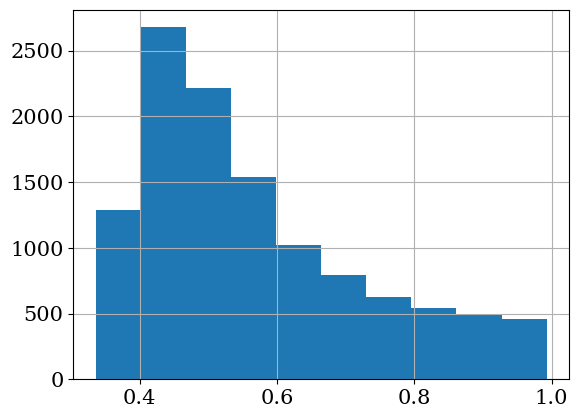

In [61]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see prediction confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. We will try to use Groq's fast model, which is likely to be more accurate given that the model is trained on more data.

In [62]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [63]:
inf_df2.head(1)

author  like_count  \
0  @Gaud-fk3nv           0   

                                                                                original_text  \
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   

  published_at_date      app  \
0        2024-07-13  YouTube   

                                                                                   final_text  \
0  Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   

  hf_sentiment  hf_score  
0     positive  0.659072

# Groq API as Overall Text Sentiment Classifier
Using Groq as an overall sentiment classifier is much better. Unfortunately, it was not able to predict on 11,700 rows in one go even though data was chunked.

In [64]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [65]:
list_df[0].head()

author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                            final_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  hf_sentiment  hf_score  
0     positive  0.659072  
1     positive  0.472498  
2     positive  0.518119  
3     positive  0.748376  
4     negative  0.476746

In [66]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentiment: negative, neutral or positive.
                Also provide confidence score as a percentage. 
                Output only as a Python string with sentiment and confidence score with comma in between. 
                Example output: neutral, 0.85
                Output needs to be the Python string only. 
                No need for introduction or explanation sentences. 
                Only return: 'neutral, 0.85'
                .
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 940 ms, sys: 50.1 ms, total: 990 ms
Wall time: 2min 56s


In [67]:
groq_sentiment[:10]

['positive, 0.95',
 'positive, 0.95',
 'positive, 0.92',
 'positive, 0.85',
 'positive, 0.9',
 'positive, 0.95',
 'negative, 0.75',
 'positive, 0.98',
 'positive, 0.9',
 'positive, 0.95']

In [68]:
list_df[0]['final_text'][:10]

0             Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸
1    4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯
2                 4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮
3                         Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸
4                               4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉
5                      Yaar 4ra pe cricket betting ka maza alag hi hai, odds bhi bohot sahi hote hain 🏏😎
6             Bhai 4RA ka interface user-friendly hai, fair betting aur odds se aur bhi maza aata hai 📱🔥
7                      Haan yaar, 4RA pe odds bohot achhe hote hain, har bet pe fair chance milta hai 😃🔥
8                4ra pe cricket, casino sab pe fair odds hote hain, jeetne ka mauka barabar milta hai 🏆😎
9             4rabet pe ab tak jitni bhi winnings mili 

Groq definitely has better intelligence than HuggingFace's model. Most likely due to model architecture and training data. Really enjoying the accuracy of predictions, ease of API use and last but not least, the speed. 

* [x] add groq predictions to df
* [x] split string of prediction and prediction score into own columns
* [x] depict comparative graph between hf_score and groq_score
* [x] try to loop through predictions for ~11,700 row df

In [69]:
# add 100 predictions to 100-row df

list_df[0]['groq_sentiment'] = groq_sentiment
list_df[0].head()

author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                            final_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  hf_sentiment  hf_score  groq_sentiment  
0     positive  0.659072  positive, 0.95  
1     positive  0.472498  positive, 0.95  
2     positive  0.518119  positive, 0.92  
3     positive  0.748376  positive, 0.85  
4     negative  0.476746   positive, 0.9

In [70]:
# split string on delimiter comma to create sentiment string column and prediction confidence score column
# cast score column as float

list_df[0][['groq_sentiment', 'groq_score']] = list_df[0]['groq_sentiment'].str.split(',', expand=True)
list_df[0].head(2)

author  like_count  \
0       @Gaud-fk3nv           0   
1  @user-wq2re1rd6o           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   

                                                                                            final_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   

  hf_sentiment  hf_score groq_sentiment groq_score  
0     positive  0.659072       positive       0.95  
1     positive  0.472498       positive       0.95

In [71]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    59
neutral     24
negative    17
Name: count, dtype: int64

In [72]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95                  25
0.92                  14
0.9                    8
0.98                   8
0.93                   7
0.75                   5
0.85                   3
0.99                   2
0.73                   2
0.83                   2
0.65                   2
0.97                   2
0.72                   2
0.96                   2
0.86                   2
0.7                    1
0.58                   1
0.53                   1
0.94                   1
0.71                   1
0.6666666666666666     1
0.67                   1
0.88                   1
0.45                   1
0.6                    1
0.78                   1
0.25                   1
0.76                   1
0.82                   1
Name: count, dtype: int64

In [73]:
# Clean up API output
list_df[0]['groq_sentiment'] = list_df[0]['groq_sentiment'].str.lower()

def remove_extra_quotes(col):
    return col.str.replace("'", "")
 
list_df[0]['groq_sentiment'] = remove_extra_quotes(list_df[0]['groq_sentiment'])
list_df[0]['groq_score'] = remove_extra_quotes(list_df[0]['groq_score'])

In [74]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    59
neutral     24
negative    17
Name: count, dtype: int64

In [75]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95                  25
0.92                  14
0.9                    8
0.98                   8
0.93                   7
0.75                   5
0.85                   3
0.99                   2
0.73                   2
0.83                   2
0.65                   2
0.97                   2
0.72                   2
0.96                   2
0.86                   2
0.7                    1
0.58                   1
0.53                   1
0.94                   1
0.71                   1
0.6666666666666666     1
0.67                   1
0.88                   1
0.45                   1
0.6                    1
0.78                   1
0.25                   1
0.76                   1
0.82                   1
Name: count, dtype: int64

In [76]:
# Convert string into float
list_df[0]['groq_score'] = list_df[0]['groq_score'].astype(float)

<Axes: >

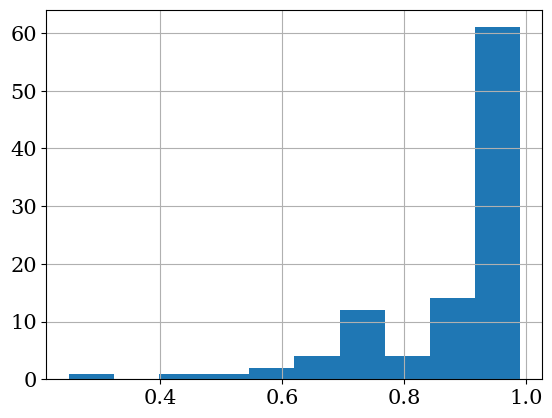

In [77]:
# Let's take a look at Groq's prediction score distribution.
# Hopefully, it is better than 0.4 range which was where HF sentiment hovered.

list_df[0]['groq_score'].hist()

Very nice. Confidence is mostly > 0.9!

____
# Groq at scale unfortunately does not work. 

I tried below algorithm but the output never came out after waiting for 4 hours of run time. This was the predicted computation time because took 2 minutes to do 100 rows of inference.

* [x] Just need to loop through list_df to create 117 diff prediction lists for each 100 block of rows
* [x] add each of the 117 lists to each df 
* [x] concat df's to blank df (11,700 total rows should be final df count)

In [78]:
# # fxn to get prediction per df with 100 rows only
# def groq_predictions(df):
    
#     #Checking to see if for loop without fxn works
#     groq_sentiment = [] # to store predictions
#     for text in df['final_text']: #using one chunk of 100 rows only, looping through text fed into model
#         chat_completion = client.chat.completions.create( #task performed on each comment
#             messages=[
#                 {
#                     "role": "user",
#                     "content": '''

#                     Please classify the following comment with a sentiment: negative, neutral or positive.
#                     Also provide confidence score as a percentage. 
#                     Output only as a Python string with sentiment and confidence score with comma in between. 
#                     Example output: neutral, 0.85
#                     Output needs to be the Python string only. 
#                     No need for introduction or explanation sentences. 
#                     Only return: 'neutral, 0.85'
#                     .
#                     This is the comment to classify sentiment on:
#                     '''
#                     + text,
#                 }
#             ],
#             model="llama3-8b-8192",
#         )
#         res = chat_completion.choices[0].message.content

#         groq_sentiment.append(res) #adding prediction to list to eventually append to df
    
#     return groq_sentiment

In [79]:
# # This whole thing will take >~4 hours...added progress bar to keep track

# df0 = pd.DataFrame()

# for df in tqdm_notebook(list_df, desc="PROGRESS"): # this will loop through 117 x 
#     # function to create predictons from 100 row df's final_text col
#     groq_sentiment = groq_predictions(df)

#     # add list to df
#     df['groq_sentiment'] = groq_sentiment

#     # add this to df0
#     df0 = pd.concat([df0, df])

# # output final big df. hopefully rows add up to: 117,000  
# df0.info()

Got this error after trying to do 11,700 predictions in 100-row chunks:

_InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}_

Based on their doc's: 503 Service Unavailable: The server is not ready to handle the request, often due to maintenance or overload. Wait before retrying the request.

After trying one more time, got the below error. 
_InternalServerError: upstream connect error or disconnect/reset before headers. reset reason: connection timeout_

Will just work with Groq's 100 predictions and PyABSA 117 row output. :)
___

## Emotion Classification

In [80]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [81]:
%%time

# Info pg: https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 16min 39s, sys: 4.1 s, total: 16min 43s
Wall time: 8min 26s


author  like_count  \
0          @Gaud-fk3nv           0   
1     @user-wq2re1rd6o           0   
2         @HYDGAMER786           0   
3  @NamitaMondal-zw5yh           0   
4    @GuduPujari-iu7vp           0   

                                                                                         original_text  \
0           Mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       Bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  published_at_date      app  \
0        2024-07-13  YouTube   
1        2024-07-13  YouTube   
2        2024-07-13  YouTube   
3        2024-07-13  YouTube   
4        2024-07-13  YouTube   

                                                                                            final_text  \
0           mujhe 4ra ka system transparent lagta hai, hamesha fair betting aur winnings milti hain 🎉💸   
1  4ra pe winnings hamesha timely milti hain, kabhi delay nahi hota, bohot trustworthy platform hai 😃💯   
2               4rabet pe live betting ka thrill hai, fair odds ke saath jeetne ka chance bhi zyada 💥🎮   
3                       bhai 4rabet pe betting kaafi fair hoti hai, winnings bhi genuine lagte hain 😍💸   
4                             4rabet pe betting karne ka pura maza hai, kabhi bhi unfair nahi lagta 💸🎉   

  hf_sentiment  hf_score hf_emotion  
0     positive  0.659072        joy  
1     positive  0.472498        joy  
2     positive  0.518119        joy  
3     positive  0.748376        joy  
4     negative  0.476746      anger

Emotion classifier is somewhat off, but does help augment HF sentiment classification when both agree and are right in sentiment.

## Sentiment and Emotion over Time

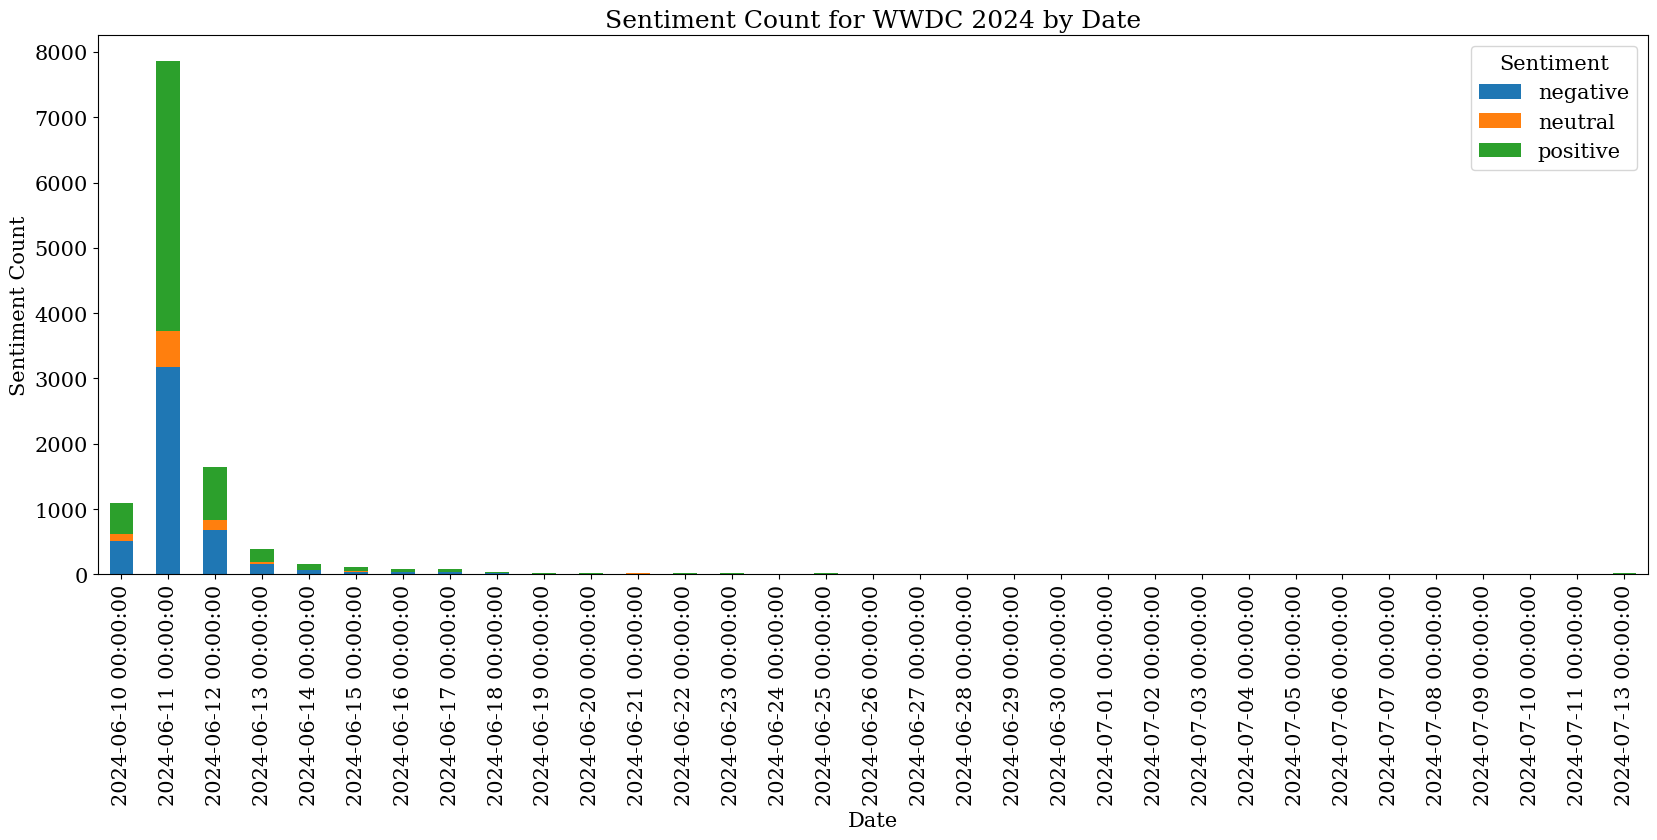

In [82]:
# For YouTube and Reddit users

# Group by hf sentiment label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(20, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

Most comments made on 6.11.24. And there is almost a split in sentiment between positive and negative. Mostly positive across days. Let's take a look at the emotion breakdown. 

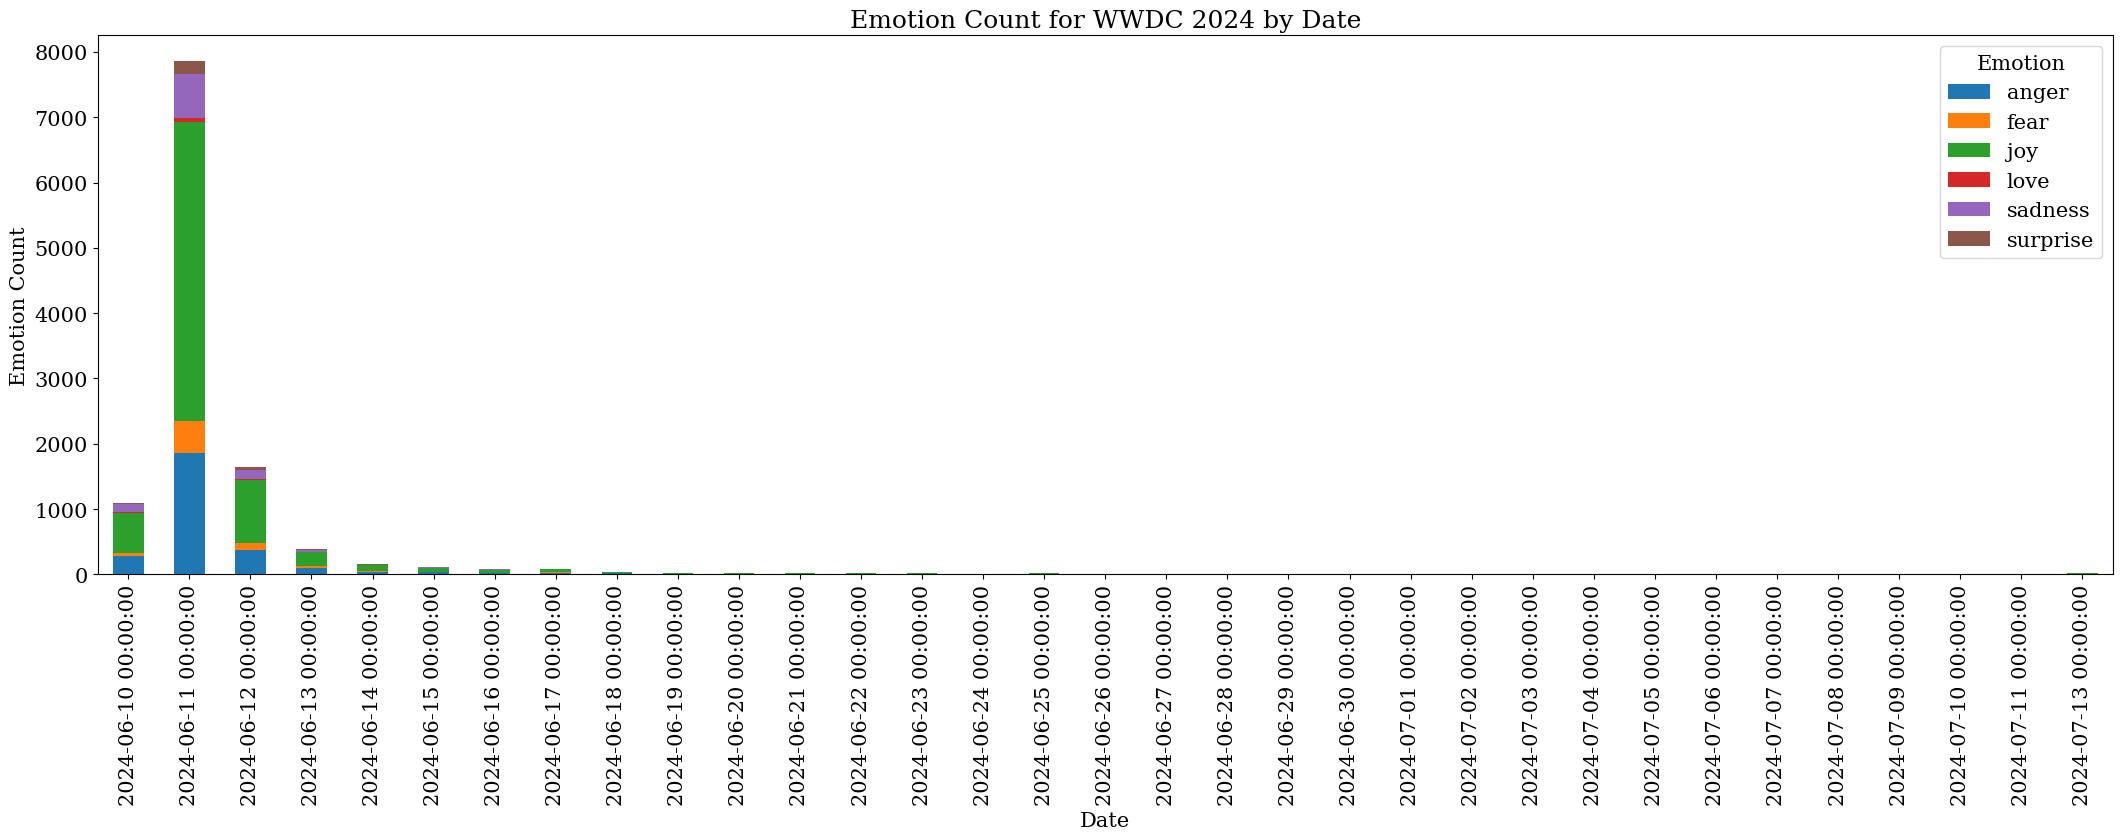

In [83]:
# Group by hf emotion label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=90)
plt.legend(title='Emotion')
plt.show()

With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA)
Trying to get more granular with sentiment analysis. E.g. What particular aspects from comments/features lead to joy/anger?

## Using General Aspect Extractor

In [84]:
# just pick a sample from df to perform general aspect-based sentiment analysis to see its performance
inf_df2_percent = inf_df2.sample(frac=0.01)
inf_df2_percent = inf_df2_percent.reset_index(drop=True)
len(inf_df2_percent)

117

In [85]:
# Let us try HuggingFace model for Aspect Based Sentiment Analysis
# Ref: https://huggingface.co/yangheng/deberta-v3-large-absa-v1.1

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [86]:
%%time

aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

inf_df2_percent['absa_gen'] = inf_df2_percent.apply(lambda row: absa_general(row['final_text']), axis=1)

CPU times: user 30min 40s, sys: 3.26 s, total: 30min 43s
Wall time: 15min 27s


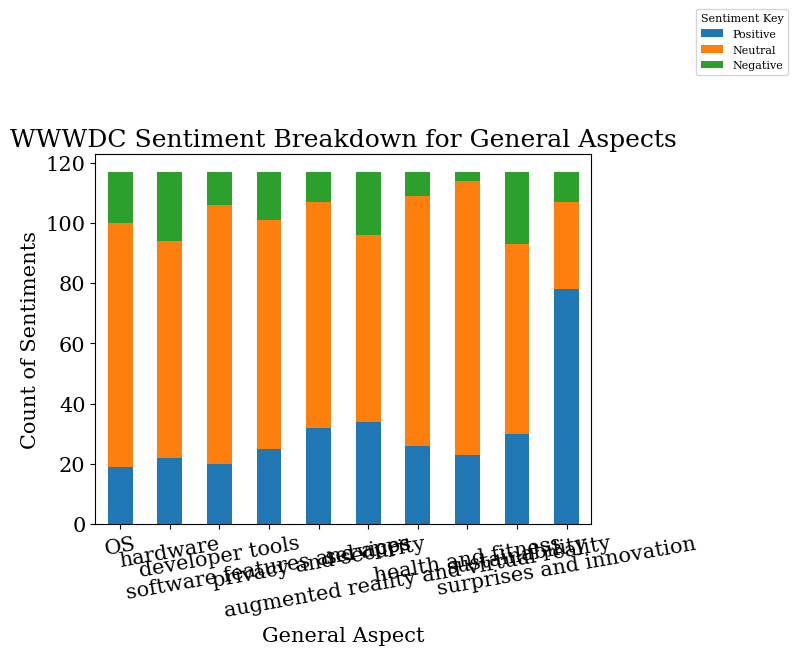

In [87]:
# Extract keys and create new columns
for key in inf_df2_percent['absa_gen'][0].keys():
    inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = inf_df2_percent[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('WWWDC Sentiment Breakdown for General Aspects')
plt.xlabel('General Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation= 10)
plt.rcParams["figure.figsize"] = (15,3)
plt.rcParams.update({'font.size': 8})


# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.2, 1.2), loc='lower left')

# Adjust the layout to make room for the legend
# plt.tight_layout()

# Show the plot
plt.show()

This is only based on a percentage of the original df - around 117 rows only. The doubtful sentiment classifications and knowing the general sentiment already of commenters' sentiment on specific topics, the model seemed to not have performed well. At least we know now the model's limitations given not that much data it was fed as well as the model most likely not being trained on Conference feedback data. Looking back at the reference page, the training data and fine-tuning data was from feedback from restaurants, tweets, etc, not necessarily new release comments. So the low interpretation quality makes sense.

## Using PyABSA

In [88]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-14 00:06:06] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-14 00:06:06] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-14 00:06:06] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-14 00:06:06] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-14 00:06:16] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-14 00:06:16] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-14 00:06:16] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-14 00:06:16] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-14 00:06:16] (2.4.1.post1) model: None
[2024-07-14 00:06:16] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-14 0

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



___
## PyABSA on whole df would take approximately 8 hours to run and possibly cause notebook to crash.

In [89]:
# create blank df to add subsequent df's to it
# loop through each 117 100-row df's
# add new PyABSA prediction column
# concat all 117 df's together

# df0 = pd.DataFrame()
# for df in tqdm_notebook(list_df, desc="PROGRESS"):
    
#     df['absa_sp'] = df['final_text'].apply(lambda x: absa_sp([x]))
#     df0 = pd.concat([df0, df])
    
# df0.info()

___

# PyABSA on 117 rows of data only

In [90]:
%%time

# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


inf_df2_percent['absa_sp'] = inf_df2_percent['final_text'].apply(lambda x: absa_sp([x]))

[2024-07-14 00:06:26] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-14 00:06:26] (2.4.1.post1) Example 0: 32 seconds ago is crazy


/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-07-14 00:06:30] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-14 00:06:30] (2.4.1.post1) Example 0: how can u as a black person not stand to free congo and sudan who are being used by apple
[2024-07-14 00:06:33] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-14 00:06:33] (2.4.1.post1) Example 0: thanks
[2024-07-14 00:06:39] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-14 00:06:39] (2.4.1.post1) Example 0: nice new <bg:Positive Confidence:0.9995> , mkbhd !
[2024-07-14 00:06:43] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Class

In [91]:
def aspect(x):
    return list(x.values())

def aspect_sentiment(x):
    return list(x.keys())

In [92]:
inf_df2_percent['aspect'] = inf_df2_percent.apply(lambda row: aspect(row['absa_sp']), axis=1)
inf_df2_percent['aspect'] = inf_df2_percent['aspect'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent.apply(lambda row: aspect_sentiment(row['absa_sp']), axis=1)
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.lower()
inf_df2_percent.drop(columns=['absa_sp'], inplace=True)

In [93]:
inf_df2_percent.head()

author  like_count  \
0    @duckdev9447           0   
1   @arachneplayz           0   
2  DaringDomino3s           1   
3    @M4cintoshSE           1   
4  @Thunder-vm2ug           0   

                                                                                                                                                             original_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                How can u as a Black person not stand to Free Congo and Sudan who are being used by apple   
2                                                                                                                                                                   Thanks   
3                                                                                                                                                      Nice new bg, mkbhd!   
4  As someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when I’m measuring and quoting   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-10   Reddit   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                                final_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                how can u as a black person not stand to free congo and sudan who are being used by apple   
2                                                                                                                                                                   thanks   
3                                                                                                                                                      nice new bg, mkbhd!   
4  as someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when i’m measuring and quoting   

  hf_sentiment  hf_score hf_emotion  \
0     negative  0.519545       fear   
1     negative  0.428359      anger   
2     positive  0.949521        joy   
3     positive  0.866794        joy   
4     positive  0.763985        joy   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0        {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Positive', 'hardware': 'Positive', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainabi

### Auditing PyABSA Inference

In [94]:
inf_df2_percent.head()

author  like_count  \
0    @duckdev9447           0   
1   @arachneplayz           0   
2  DaringDomino3s           1   
3    @M4cintoshSE           1   
4  @Thunder-vm2ug           0   

                                                                                                                                                             original_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                How can u as a Black person not stand to Free Congo and Sudan who are being used by apple   
2                                                                                                                                                                   Thanks   
3                                                                                                                                                      Nice new bg, mkbhd!   
4  As someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when I’m measuring and quoting   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-10   Reddit   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                                final_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                how can u as a black person not stand to free congo and sudan who are being used by apple   
2                                                                                                                                                                   thanks   
3                                                                                                                                                      nice new bg, mkbhd!   
4  as someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when i’m measuring and quoting   

  hf_sentiment  hf_score hf_emotion  \
0     negative  0.519545       fear   
1     negative  0.428359      anger   
2     positive  0.949521        joy   
3     positive  0.866794        joy   
4     positive  0.763985        joy   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0        {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Positive', 'hardware': 'Positive', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainabi

In [95]:
inf_df2_percent.tail()

author  like_count  \
112         @belsnickel431           1   
113         @RaffaelPallus           0   
114  @milztempelrowski9281           0   
115     @analogecstasy4654           0   
116             -AngryPope           1   

                                                                                                                                                     original_text  \
112                                                                                   MKBHD showing the unsupported BVG (Berlin public Transport) App made my day!   
113                                                                                                                      Maybe also the best to put backdoor in AI   
114                                     Jack Ma did it first. \nIn that very funny debate with Elon a few years ago in Shanghai.\n"I call it Alibaba Intelligence"   
115  Apple is such a boring company now. Can’t wait for a trendy, new technology company to come along and do actual, innovative work again and steal their lunch!   
116                                                                                                                         I heard that it’s available in Toledo.   

    published_at_date      app  \
112        2024-06-11  YouTube   
113        2024-06-11  YouTube   
114        2024-06-11  YouTube   
115        2024-06-11  YouTube   
116        2024-06-11   Reddit   

                                                                                                                                                        final_text  \
112                                                                                   mkbhd showing the unsupported bvg (berlin public transport) app made my day!   
113                                                                                                                      maybe also the best to put backdoor in ai   
114                                       jack ma did it first.  in that very funny debate with elon a few years ago in shanghai. "i call it alibaba intelligence"   
115  apple is such a boring company now. can’t wait for a trendy, new technology company to come along and do actual, innovative work again and steal their lunch!   
116                                                                                                                         i heard that it’s available in toledo.   

    hf_sentiment  hf_score hf_emotion  \
112     negative  0.507934    sadness   
113     positive  0.706679        joy   
114     positive  0.444963   surprise   
115     positive  0.627536        joy   
116     positive  0.459166        joy   

                                                                                                                                                                                                                                                                                                                                         absa_gen  \
112    {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainability': 'Positive', 'surprises and innovation': 'Positive'}   
113  {'OS': 'Positive', 'hardware': 'Positive', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainability': 'Positive', 'surprises and innovation': 'Positive'}   
114            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral',

Small sample, but PyABSA is somewhat more accurate than emotion classifier and much better than Hugging Face's sentiment classifier. Pretty spot-on with most aspects though. Groq wins! :)

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

## POC:

In [96]:
content = '''
apple intelligence coping android and samsung ai. very intelligent. 2.0update. just go android 
and youll get 100% custumization not just 10% with iphone. in android samsung tablet s9ultra 
we have myscript calculator app and does very advanced calculations with samsung s pen does all 
your math homework and we had this app for 7yrs ago so bravo now u have a calculator app on ipad m4. 
man apple users get so exited for stuff we had for years on android. exept wen apple users always 
think oh apple does it better yea right... no brain.
'''

doc = nlp(content)

for ent in doc.ents:
	print(ent.text, ent.start_char, ent.end_char, ent.label_)

samsung 39 46 ORG
100% 111 115 PERCENT
just 10% 134 142 PERCENT
android samsung 159 174 ORG
s9ultra 182 189 LAW
samsung s pen 264 277 PERSON
7yrs ago 331 339 DATE
m4 385 387 GPE
years 441 446 DATE
wen apple 465 474 PERSON


In [97]:
displacy.render(doc, style="ent")

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [98]:
entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
ner_df

text     type            lemma
0          samsung      ORG          samsung
1             100%  PERCENT             100%
2         just 10%  PERCENT         just 10%
3  android samsung      ORG  android samsung
4          s9ultra      LAW          s9ultra
5    samsung s pen   PERSON    samsung s pen
6         7yrs ago     DATE          7yr ago
7               m4      GPE               m4
8            years     DATE             year
9        wen apple   PERSON        wen apple

The type and lemma are rough. There is better output from Aspect Based Sentiment Analysis where aspects are drawn out. And sentiment is tied to it.

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: number likes, sentiment/emotion 
* compare YouTube and Reddit comments across like count (popularity) and overall sentiment (choose more accurate classifier: absa) and overall emotion

* First pass: to see how Radar Graph works
1. [x] preview like count across YouTube and Reddit
1. [x] pick best overall sentiment classifier (Groq) FOR NOW, PyABSA is more accurate than emotion classifier on overall comment
1. [x] will need to transform sentiment classification into grades
1. [x] create Radar graph to see how each social media platforms' sentiment compares across different metrics

* Second pass: Examine most talked about releases and sentiment tied to it
1. [x] grab data from absa sp
1. [x] do an aggregation with aspect for sentiment and popularity (like rating, num reviews)

In [99]:
inf_df2_percent.head(1)

author  like_count            original_text published_at_date  \
0  @duckdev9447           0  32 seconds ago is crazy        2024-06-11   

       app               final_text hf_sentiment  hf_score hf_emotion  \
0  YouTube  32 seconds ago is crazy     negative  0.519545       fear   

                                                                                                                                                                                                                                                                                                                                 absa_gen  \
0  {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}   

   ... developer tools software features and apps privacy and security  \
0  ...         Neutral                    Neutral              Neutral   

   services augmented reality and virtual reality health and fitness  \
0  Negative                               Neutral            Neutral   

  sustainability surprises and innovation aspect aspect_sentiment  
0       Negative                  Neutral                          

[1 rows x 22 columns]

In [100]:
query = """
select app
, sum(like_count) as total_liked_comments
from inf_df2_percent
group by 1
"""

duckdb.query(query).df()

app  total_liked_comments
0   Reddit                 459.0
1  YouTube                 100.0

A lot more activity on YouTube

In [101]:
query = """
select app 
, hf_emotion
, count(hf_emotion) as total_emotion_count
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app hf_emotion  total_emotion_count
0  YouTube        joy                   61
1  YouTube      anger                   18
2   Reddit        joy                   11
3  YouTube       fear                   10
4  YouTube    sadness                    6
5  YouTube   surprise                    4
6   Reddit      anger                    4
7   Reddit    sadness                    2
8  YouTube       love                    1

Across both social media platforms, comments are dominated by joy then anger.

In [102]:
query = """
select app
, aspect
, count(aspect) as total_aspects
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

app                aspect  total_aspects
0   YouTube                                   24
1   YouTube                 apple             11
2    Reddit                                   10
3   YouTube                iphone              7
4   YouTube                  ipad              6
5   YouTube               android              4
6   YouTube                  apps              3
7   YouTube                 notes              3
8   YouTube                tinder              2
9   YouTube                   app              2
10  YouTube                   ios              2
11  YouTube                photos              1
12  YouTube                  icon              1
13  YouTube               classes              1
14  YouTube               waiting              1
15   Reddit                  spam              1
16  YouTube                    bg              1
17  YouTube          after vision              1
18  YouTube                    dl              1
19  YouTube                    ai              1
20   Reddit                airuns              1
21  YouTube                  elon              1
22  YouTube                google              1
23  YouTube                 emoji              1
24  YouTube                 icons              1
25  YouTube                 board              1
26  YouTube      jailbreak themes              1
27  YouTube            homescreen              1
28  YouTube    home screenmulti -              1
29  YouTube                colors              1
30  YouTube              backdoor              1
31  YouTube                  jack              1
32  YouTube               iphones              1
33  YouTube              lighting              1
34   Reddit                   ios              1
35  YouTube             partnered              1
36  YouTube         accessibility              1
37  YouTube               patrick              1
38  YouTube          accesibility              1
39  YouTube                upload              1
40  YouTube                  song              1
41  YouTube               widgets              1
42  YouTube                  wait              1
43  YouTube            icon packs              1
44  YouTube                  chef              1
45   Reddit                device              1
46  YouTube            iphonelife              1
47   Reddit                  ipad              1
48  YouTube             sainsbury              1
49  YouTube                  tech              1
50   Reddit  planned obsolescence              1
51  YouTube                 audio              1
52   Reddit                 notes              1
53  YouTube            clipboards              1

A lot of comments had unknown sentiment, which is good to know. With comments that were easily classified though, PyABSA produced negative for YouTube's top sentiment and neutral for Reddit's top sentiment.

In [103]:
# Creating grades from sentiments - only using emotion, and aspect based sentiment classification

query = """
select *
, case when hf_emotion IN ('anger', 'fear') then 1
when hf_emotion IN ('sadness', 'surprise') then 2
when hf_emotion IN ('joy', 'love') then 3
else 0
end as emotion_grade
, case when aspect_sentiment = 'negative' then 1
when aspect_sentiment = 'neutral' then 2
when aspect_sentiment = 'positive' then 3
else 0
end as aspect_sentiment_grade
from inf_df2_percent
"""

inf_df2_percent_grades = duckdb.query(query).df()
inf_df2_percent_grades.head()

author  like_count  \
0    @duckdev9447           0   
1   @arachneplayz           0   
2  DaringDomino3s           1   
3    @M4cintoshSE           1   
4  @Thunder-vm2ug           0   

                                                                                                                                                             original_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                How can u as a Black person not stand to Free Congo and Sudan who are being used by apple   
2                                                                                                                                                                   Thanks   
3                                                                                                                                                      Nice new bg, mkbhd!   
4  As someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when I’m measuring and quoting   

  published_at_date      app  \
0        2024-06-11  YouTube   
1        2024-06-11  YouTube   
2        2024-06-10   Reddit   
3        2024-06-11  YouTube   
4        2024-06-11  YouTube   

                                                                                                                                                                final_text  \
0                                                                                                                                                  32 seconds ago is crazy   
1                                                                                how can u as a black person not stand to free congo and sudan who are being used by apple   
2                                                                                                                                                                   thanks   
3                                                                                                                                                      nice new bg, mkbhd!   
4  as someone who does contracting work, the math notes is gonna be so helpful and save a lot of time, especially in front of the customers when i’m measuring and quoting   

  hf_sentiment  hf_score hf_emotion  \
0     negative  0.519545       fear   
1     negative  0.428359      anger   
2     positive  0.949521        joy   
3     positive  0.866794        joy   
4     positive  0.763985        joy   

                                                                                                                                                                                                                                                                                                                                       absa_gen  \
0        {'OS': 'Negative', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}   
1            {'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}   
2  {'OS': 'Positive', 'hardware': 'Positive', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainabi

In [104]:
# get relevant columns (app, num likes, emotion_grade, aspect_sentiment_grade) and set app as index

query = """
select app
, round(avg(like_count)) as avg_like_count
, round(avg(emotion_grade)) as avg_emotion
, round(avg(aspect_sentiment_grade)) as avg_aspect_sentiment
from inf_df2_percent_grades
group by 1
"""

radar_df = duckdb.query(query).df()

# Set app as index
radar_df.set_index('app', inplace=True)
radar_df

avg_like_count  avg_emotion  avg_aspect_sentiment
app                                                       
YouTube             1.0          2.0                   1.0
Reddit             27.0          2.0                   1.0

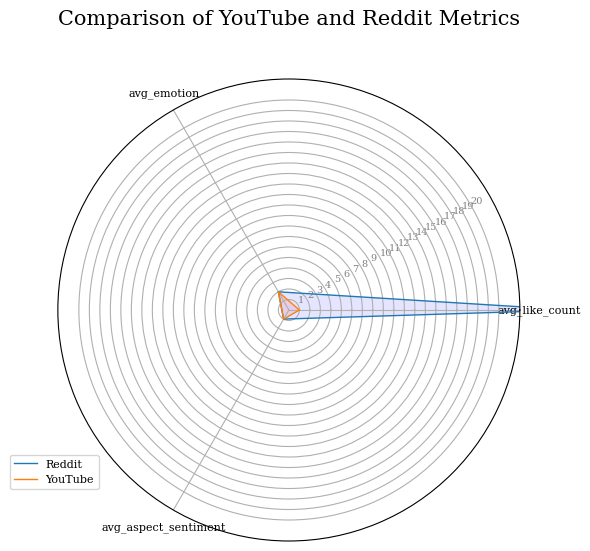

In [105]:
# Data preparation
labels = list(radar_df)
stats_reddit = radar_df.loc['Reddit'].tolist()
stats_youtube = radar_df.loc['YouTube'].tolist()

# Completing the loop
stats_reddit += stats_reddit[:1]
stats_youtube += stats_youtube[:1]

# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw y-labels
ax.set_rlabel_position(30)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
           ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"], 
           color="grey", size=7) #this may need to be generarlized due to hard-coding axis for metrics
plt.ylim(0, 22)

# Plot data
ax.plot(angles, stats_reddit, linewidth=1, linestyle='solid', label='Reddit')
ax.fill(angles, stats_reddit, 'b', alpha=0.1)

ax.plot(angles, stats_youtube, linewidth=1, linestyle='solid', label='YouTube')
ax.fill(angles, stats_youtube, 'r', alpha=0.1)

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(0.1, 0.1))

# Title
plt.title('Comparison of YouTube and Reddit Metrics', size=15, color='black', y=1.1)

# Show plot
plt.show()

Based on this, we see that YouTube wins over Reddit with popularity votes. Would be nice to see what exactly are  the most popular comments talking about.

# Most popular topics and emotion sentiment across YouTube and Reddit

In [106]:
query = """
select case when aspect IN ('iphone', 'iphones') then 'iphone' else aspect end as aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
"""

duckdb.query(query).df()

aspect  total_occurence
0                  apple               11
1                 iphone                8
2                   ipad                7
3                android                4
4                  notes                4
5                    ios                3
6                   apps                3
7                    app                2
8                 tinder                2
9                   icon                1
10                    bg                1
11              lighting                1
12             partnered                1
13         accessibility                1
14                  spam                1
15               patrick                1
16          accesibility                1
17                upload                1
18                airuns                1
19                device                1
20                  wait                1
21            icon packs                1
22             sainsbury                1
23                  tech                1
24                 audio                1
25            clipboards                1
26                  song                1
27               widgets                1
28                photos                1
29                google                1
30                 emoji                1
31                 icons                1
32                 board                1
33      jailbreak themes                1
34            homescreen                1
35  planned obsolescence                1
36               classes                1
37               waiting                1
38          after vision                1
39                    dl                1
40                    ai                1
41                  elon                1
42                  chef                1
43            iphonelife                1
44    home screenmulti -                1
45                colors                1
46              backdoor                1
47                  jack                1

We can see here that past the high-level topic of apple, most talked about WWDC topics were iphone, iPad and app's in general. Given the long tail, there needs to be more data. 

In [107]:
# Overall sentiment of most talked about topics from WWDC

query = """

with cte as (
select case when aspect IN ('iphone', 'iphones') then 'iphone' else aspect end as aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
)

select aspect
, aspect_sentiment
from inf_df2_percent
where aspect in (select aspect from cte limit 8) 
"""

inf_df2_percent_as = duckdb.query(query).df()
inf_df2_percent_as

aspect aspect_sentiment
0     apple          neutral
1     notes         positive
2       ios         negative
3      apps         negative
4     apple          neutral
5   android         negative
6    tinder          neutral
7       ios          neutral
8      ipad          neutral
9      ipad         positive
10   iphone          neutral
11    notes         positive
12   iphone          neutral
13     ipad          neutral
14     apps         negative
15    apple         positive
16   iphone         positive
17      ios          neutral
18    apple         negative
19    apple          neutral
20    apple         negative
21  android         negative
22   iphone          neutral
23    apple          neutral
24    apple         positive
25  android          neutral
26  android          neutral
27   iphone          neutral
28   tinder          neutral
29    apple         negative
30    apple          neutral
31     ipad         positive
32     ipad          neutral
33     apps          neutral
34   iphone         negative
35     ipad         positive
36    notes         positive
37   iphone          neutral
38     ipad          neutral
39    notes         positive
40    apple         negative

In [108]:
# Create the sunburst chart
fig = px.sunburst(
    inf_df2_percent_as,
    path=['aspect', 'aspect_sentiment'],
    color='aspect_sentiment',
    color_discrete_map={'positive':'green', 'neutral':'grey', 'negative':'red'},
    title='Sentiment Analysis of Most Talked About Topics'
)

# Show the plot
fig.show()

At the center, we can see the most talked about topics across YouTube and Reddit. The outer layer shows the different sentiments per topic. iOS and their competitor, Samsung had negative sentiment mostly tied to it. However, things looked good with iPad only (most likely due to the impressive Calculator app). There was positive sentiment for apple, but it was not the dominant emotion. 

It looks like from the WWDC conference, iphone, iPad, iOS, android/Samsung (notes), app and features were the most talked about topics. Looks like Apple needs to work on their reputation even after catch up with AI frontier.